In [1]:
%run setup_PS_data_multi.ipynb
import pandas as pd
import math, cmath
from tqdm import tqdm
print('------------------------------------')
print(f'{len(sessions)} sessions are loaded')

Now loading mouse RL070, run 22
Now loading mouse RL070, run 23
Now loading mouse RL070, run 24
Now loading mouse RL070, run 27
Now loading mouse RL070, run 28
microcontroller trial starts occur on average -70.14 ms from galvo trial starts
photo stim occurences: {0: 127, 1: 140, 2: 119}
Occurence table:
[[123.   4.]
 [119.  21.]
 [ 80.  39.]]
375 / 375 non nan trials identified
Numbers of PS cells: [  0   5  10  20  30  40  50 150]
succesfully loaded mouse RL070, run 28
Now loading mouse RL070, run 29
microcontroller trial starts occur on average nan ms from galvo trial starts
photo stim occurences: {0: 96, 1: 93, 2: 90}
Occurence table:
[[78. 18.]
 [46. 47.]
 [35. 55.]]
263 / 263 non nan trials identified
Numbers of PS cells: [  0   5  10  20  30  40  50 150]
succesfully loaded mouse RL070, run 29
Now loading mouse J047, run 7
Now loading mouse J048, run 15
Now loading mouse J048, run 16
Now loading mouse J048, run 18
Now loading mouse J048, run 19
Now loading mouse J048, run 26
Now l

# START

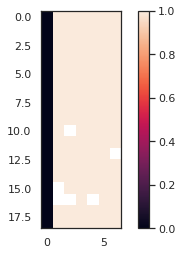

In [2]:


def beh_metric(sessions, metric='accuracy',
               stim_array=[0, 5, 10, 20, 30, 40, 50]):
    acc = np.zeros((len(sessions), len(stim_array)))
    for i_session, session in sessions.items():
        for i_stim, stim in enumerate(stim_array):
            trial_inds = np.where(session.trial_subsets == stim)[0]
            tp = np.sum(session.outcome[trial_inds] == 'hit')
            fp = np.sum(session.outcome[trial_inds] == 'fp')
            tn = np.sum(session.outcome[trial_inds] == 'cr')
            fn = np.sum(session.outcome[trial_inds] == 'miss')
            assert (tp + fp + tn + fn) == len(session.outcome[trial_inds])
            if metric == 'accuracy':
                acc[i_session, i_stim] = (tp + tn) / (tp + fp + tn + fn)
            elif metric == 'sensitivity':
                acc[i_session, i_stim] = tp / (tp + fp)
    return acc

plt.imshow(beh_metric(sessions=sessions, metric='sensitivity'))
plt.colorbar()

In [3]:
def fun_return_2d(data):  # possibly add fancy stuff
    return np.mean(data, 2)

def angle_vecs(v1, v2):
    assert v1.shape == v2.shape
    v1, v2 = np.squeeze(v1), np.squeeze(v2)
    tmp = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    rad = np.arccos(tmp)
    deg = rad * 360 / (2 * np.pi)
    return deg

def mean_angle(deg):
    return math.degrees(cmath.phase(sum([cmath.rect(1, math.radians(d)) for d in deg])/len(deg)))

def create_dict_pred(nl, train_proj, lt):
        dict_predictions_test = {x + '_test': np.array([]) for x in nl}  # make dicts to save
        dict_predictions_train = {x + '_train': np.array([]) for x in nl}
        if train_proj:
            for x in lt:
                dict_predictions_train[f'pred_{x}_train_proj'] = np.array([])
                dict_predictions_test[f'pred_{x}_test_proj'] = np.array([])
        if len(lt) == 2:
            dict_predictions_train['angle_decoders'] = np.array([])
        return dict_predictions_train, dict_predictions_test

# for ii in range(len(sessions)):
#     sessions[ii].shuffle_labels()


In [4]:
def train_test_all_sessions(sessions, trial_times_use=None, verbose=2, list_test = ['dec', 'stim'],
                            hitmiss_only=False, cv_regularizer = False, include_150 = False,
                            n_split = 4, include_autoreward=True, neurons_selection='all',
                            C_value=0.2, train_projected=False):
    if hitmiss_only:
        if verbose >= 1:
            print('Using hit/miss trials only.')
        if 'stim' in list_test:
            list_test.remove('stim')  # no point in estimating stim, because only PS
            
    name_list = ['autorewarded']  # names of details to save - whether autorewrd trial or not
    for nn in list_test:
        name_list.append('pred_' + nn)  # prediction
    for nn in ['dec', 'stim']:
        name_list.append('true_' + nn)  # ground truth
        
    mouse_list = np.unique([ss.mouse for _, ss in sessions.items()])
    df_prediction_train, df_prediction_test = dict(), dict()
    if cv_regularizer:
        best_c = {f'{x.mouse}R{x.run_number}': {} for _, x in sessions.items()}
    if verbose >= 2:
        print(mouse_list)
    for mouse in mouse_list:
        angle_decoders = np.zeros((len(sessions), n_split))
        dict_predictions_train, dict_predictions_test = create_dict_pred(nl=name_list, train_proj=train_projected, lt=list_test)
        for i_session, session in sessions.items():  # loop through sessions/runs and concatenate results (in dicts)
            if session.mouse == mouse:  # only evaluate current mouse
                if verbose >= 1:
                    print(f'Mouse {mouse}, Starting loop {i_session + 1}/{len(sessions)}')
                if trial_times_use is None:
                    trial_frames_use = session.filter_ps_array[(session.final_pre_gap_tp + 1):(session.final_pre_gap_tp + 6)]
                    print('WARNING: trial_times undefined so hard-coding them (to 5 post-stim frames)')
                else:
                    trial_frames_use = []
                    for tt in trial_times_use:
                        trial_frames_use.append(session.filter_ps_array[np.where(session.filter_ps_time == tt)[0][0]])  # this will throw an error if tt not in filter_ps_time
                    trial_frames_use = np.array(trial_frames_use)
                    assert len(trial_times_use) == len(trial_frames_use)
                    if verbose >= 2:
                        print(trial_times_use, trial_frames_use)

                ## Set neuron inds
                if neurons_selection == 'all':
                    neurons_include = np.arange(session.behaviour_trials.shape[0])
                elif neurons_selection == 's1':
                    neurons_include = session.s1_bool
                elif neurons_selection == 's2':
                    neurons_include = session.s2_bool
                if verbose >= 2:
                    print(f'n neurons: {np.sum(neurons_include)}/{len(neurons_include)}, {neurons_selection}')
                ## Set trial inds
                if include_150 is False:
                    trial_inds = np.where(session.photostim < 2)[0]
                else:
                    trial_inds = np.arange(len(session.photostim))

                if hitmiss_only:
                    hitmiss_trials = np.where(np.logical_or(session.outcome == 'hit', session.outcome == 'miss'))[0]
                    if verbose == 2:
                        print(f'Size hm {hitmiss_trials.size}, trial inds {trial_inds.size}')
                    trial_inds = np.intersect1d(trial_inds, hitmiss_trials)

                if include_autoreward is False:
                    ar_exclude = np.where(session.autorewarded == False)[0]
                    if verbose == 2:
                        print(f'{np.sum(session.autorewarded)} autorewarded trials found and excluded')
                    trial_inds = np.intersect1d(trial_inds, ar_exclude)

                if verbose == 2:
                    print(f'final size {trial_inds.size}')
                n_trials = len(trial_inds)
                if verbose == 2:
                    print(f'Total number of trials is {n_trials}. Number of splits is {n_split}')

                # Prepare data with selections
                data_use = session.behaviour_trials[neurons_include, :, :]
                data_use = data_use[:, :, trial_frames_use]
                data_use = data_use[:, trial_inds, :]
                data_use = fun_return_2d(data_use)
                stand_scale = sklearn.preprocessing.StandardScaler()
                data_use = stand_scale.fit_transform(data_use)
  
                sss = sklearn.model_selection.StratifiedKFold(n_splits=n_split)  # split into n_split data folds of trials
                if verbose == 2:
                    print(f'Number of licks: {np.sum(session.decision[trial_inds])}')
                    dict_outcomes = {x: np.sum(session.outcome[trial_inds] == x) for x in np.unique(session.outcome[trial_inds])}
                    print(f'Possible trial outcomes: {dict_outcomes}')
                    dict_n_ps = {x: np.sum(session.trial_subsets[trial_inds] == x) for x in np.unique(session.trial_subsets[trial_inds])}
                    print(f'Possible stimulations: {dict_n_ps}')
                
                if cv_regularizer:
                    train_data = data_use
                    train_labels =  {'stim': session.photostim[trial_inds],
                               'dec': session.decision[trial_inds]}
                    reg_array = {'C': np.logspace(-4, 0, 20), 'class_weight': ['balanced']}
                    for x in list_test:
                        grid = sklearn.model_selection.GridSearchCV(sklearn.linear_model.LogisticRegression(),
                                                                    reg_array, cv=n_split, n_jobs=n_split)  # cv uses Strat K Fold
                        grid.fit(X=train_data.transpose(), y=train_labels[x])
                        best_c[f'{session.mouse}R{session.run_number}'][x] = grid.best_params_['C']
                    if verbose == 2:
                        print( best_c[f'{session.mouse}{session.run_number}'])
                    continue  ## Skip rest of training etc. 
                
                i_loop = 0
                for train_inds, test_inds in sss.split(X=np.zeros(n_trials), y=session.outcome[trial_inds]):  # loop through different train/test folds, concat results
                    train_data, test_data = data_use[:, train_inds], data_use[:, test_inds]
                    if i_loop == 0:
                        if verbose == 2:
                            print(f'Shape train data {train_data.shape}, test data {test_data.shape}')

                    ## Get labels and categories of trials
                    train_labels = {'stim': session.photostim[trial_inds[train_inds]],
                                    'dec': session.decision[trial_inds[train_inds]]}
                    test_labels = {'stim': session.photostim[trial_inds[test_inds]], 
                                   'dec': session.decision[trial_inds[test_inds]]}
                    if verbose == 2:
                        print(f' Number of test licks {np.sum(test_labels["dec"])}')
                    detailed_ps_labels = session.trial_subsets[trial_inds]
                    autorewarded = session.autorewarded[trial_inds]
                    assert len(train_labels['dec']) == train_data.shape[1]
                    assert len(test_labels['stim']) == test_data.shape[1]

                    ## Train logistic regression model on train data
                    dec = {}
                    for x in list_test:
                        dec[x] = sklearn.linear_model.LogisticRegression(C=C_value, class_weight='balanced').fit(
                                        X=train_data.transpose(), y=train_labels[x])

                    if len(list_test) == 2:
                        angle_decoders[i_session, i_loop] = angle_vecs(dec[list_test[0]].coef_, dec[list_test[1]].coef_)

                    if train_projected:  # project and re decode
                        dec_proj = {}
                        assert len(list_test) == 2  # hard coded that len==2 further on
                        for i_x, x in enumerate(list_test):
                            i_y = 1 - i_x
                            y = list_test[i_y]
                            assert x != y
                            enc_vector = dec[y].coef_ / np.linalg.norm(dec[y].coef_)
                            train_data_proj = enc_vector.copy() * train_data.transpose()
                            test_data_proj = enc_vector.copy() * test_data.transpose()
                            dec_proj[x] = sklearn.linear_model.LogisticRegression(C=C_value, class_weight='balanced').fit(
                                            X=train_data_proj, y=train_labels[x])

                    ## Predict test data
                    pred_proba_train = {x: dec[x].predict_proba(X=train_data.transpose())[:, 1] for x in list_test}
                    pred_proba_test = {x: dec[x].predict_proba(X=test_data.transpose())[:, 1] for x in list_test}
                    if train_projected:
                        pred_proba_train_proj = {x: dec_proj[x].predict_proba(X=train_data_proj)[:, 1] for x in list_test}
                        pred_proba_test_proj = {x: dec_proj[x].predict_proba(X=test_data_proj)[:, 1] for x in list_test}

                    ## Save results
                    for x in list_test: 
                        dict_predictions_train[f'pred_{x}_train'] = np.concatenate((dict_predictions_train[f'pred_{x}_train'], pred_proba_train[x]))
                        dict_predictions_test[f'pred_{x}_test'] = np.concatenate((dict_predictions_test[f'pred_{x}_test'], pred_proba_test[x]))
                        if train_projected:
                            dict_predictions_train[f'pred_{x}_train_proj'] = np.concatenate((dict_predictions_train[f'pred_{x}_train_proj'], pred_proba_train_proj[x]))
                            dict_predictions_test[f'pred_{x}_test_proj'] = np.concatenate((dict_predictions_test[f'pred_{x}_test_proj'], pred_proba_test_proj[x]))
                    if len(list_test) == 2:
                        dict_predictions_train['angle_decoders'] = np.concatenate((dict_predictions_train['angle_decoders'], np.zeros_like(pred_proba_train[x]) + angle_decoders[i_session, i_loop]))
                    dict_predictions_train['true_stim_train'] = np.concatenate((dict_predictions_train['true_stim_train'], detailed_ps_labels[train_inds]))
                    dict_predictions_test['true_stim_test'] = np.concatenate((dict_predictions_test['true_stim_test'], detailed_ps_labels[test_inds]))
                    dict_predictions_train['autorewarded_train'] = np.concatenate((dict_predictions_train['autorewarded_train'], autorewarded[train_inds]))
                    dict_predictions_test['autorewarded_test'] = np.concatenate((dict_predictions_test['autorewarded_test'], autorewarded[test_inds]))
                    dict_predictions_train['true_dec_train'] = np.concatenate((dict_predictions_train['true_dec_train'], train_labels['dec']))
                    dict_predictions_test['true_dec_test'] = np.concatenate((dict_predictions_test['true_dec_test'], test_labels['dec']))
                    i_loop += 1
                if verbose >= 1 and cv_regularizer:
                    print(f'C values: {best_c}')
        if cv_regularizer is False:
            if verbose == 2:
                print(f'length test: {len(dict_predictions_test["true_dec_test"])}')

            ## Put dictionary results into dataframes:
            df_prediction_train[mouse] = pd.DataFrame(dict_predictions_train)
            df_prediction_test[mouse] = pd.DataFrame(dict_predictions_test)
        else:
            if verbose >= 1:
                print(best_c)
                
    if cv_regularizer:
        return best_c   # NB output size changes
    else:
        return df_prediction_train, df_prediction_test
    
def plot_df_stats(df, xx, yy, hh, plot_line=True, xticklabels=None):
#     yy = yy + '_proj'
    if plot_line and hh is None:
        sns.pointplot(data=df, x=xx, y=yy, color='grey', ci='sd', label=None)
    elif plot_line and hh is not None:
        sns.pointplot(data=df, x=xx, y=yy, hue=hh, ci='sd', label=None)
    if hh is None:  
        tmp = sns.stripplot(x=xx, y=yy, hue=hh, data=df, linewidth=1, label=None, color='grey')
    else:  
        tmp = sns.stripplot(x=xx, y=yy, hue=hh, data=df, linewidth=1, label=None)
    if xticklabels is not None:
        tmp.set_xticklabels(xticklabels)

Mouse J048, Starting loop 3/19
Mouse J048, Starting loop 4/19
Mouse J048, Starting loop 5/19
Mouse J048, Starting loop 6/19
Mouse J048, Starting loop 7/19
Mouse J063, Starting loop 11/19
Mouse J063, Starting loop 12/19
Mouse J064, Starting loop 8/19
Mouse J064, Starting loop 9/19
Mouse J064, Starting loop 10/19
Mouse J065, Starting loop 18/19
Mouse J065, Starting loop 19/19
Mouse RL048, Starting loop 13/19
Mouse RL048, Starting loop 14/19
Mouse RL048, Starting loop 15/19
Mouse RL048, Starting loop 16/19
Mouse RL048, Starting loop 17/19
Mouse RL070, Starting loop 1/19
Mouse RL070, Starting loop 2/19


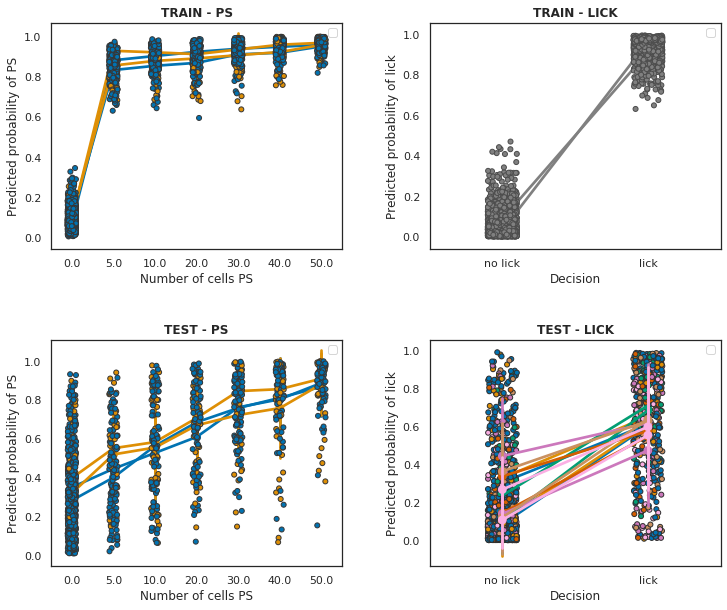

In [5]:
time_frame = 1.2
n_splits = 4

df_prediction_train, df_prediction_test = train_test_all_sessions(sessions=sessions, verbose=1, n_split=n_splits,
                                              trial_times_use=np.array([time_frame]),
                                         hitmiss_only=False,# list_test=['dec', 'stim'],
                                         include_autoreward=True, neurons_selection='s1',
                                         C_value=0.02, cv_regularizer=False, train_projected=True)

plt.rcParams['figure.figsize'] = (12, 10)
plt.subplots_adjust(wspace=0.3, hspace=0.4)
    
## NB: To not plot with hue, set hh=None
# for mouse in df_prediction_train.keys():
for mouse in ['J048', 'RL048']:
    if 'pred_stim_train' in df_prediction_train[mouse].columns:
        plt.subplot(221)
        plot_df_stats(df=df_prediction_train[mouse], xx='true_stim_train', yy='pred_stim_train', hh='true_dec_train')  # set hh=None or hh='dec_train'
        plt.xlabel('Number of cells PS'); plt.ylabel('Predicted probability of PS'); plt.title('TRAIN - PS', weight='bold')
        plt.legend([])

        plt.subplot(223)
        plot_df_stats(df=df_prediction_test[mouse], xx='true_stim_test', yy='pred_stim_test', hh='true_dec_test')  # set hh=None or hh='dec_test'
        plt.xlabel('Number of cells PS'); plt.ylabel('Predicted probability of PS'); plt.title('TEST - PS', weight='bold')
        plt.legend([])

    if 'pred_dec_train' in df_prediction_train[mouse].columns:  
        plt.subplot(222)
        plot_df_stats(df=df_prediction_train[mouse], xx='true_dec_train', yy='pred_dec_train', hh=None, xticklabels=['no lick', 'lick'])
        plt.xlabel('Decision'); plt.ylabel('Predicted probability of lick'); plt.title('TRAIN - LICK', weight='bold')
        plt.legend('No lick', 'lick')

        plt.subplot(224)
        plot_df_stats(df=df_prediction_test[mouse], xx='true_dec_test', yy='pred_dec_test', hh='true_stim_test', xticklabels=['no lick', 'lick'])
        plt.xlabel('Decision'); plt.ylabel('Predicted probability of lick'); plt.title('TEST - LICK', weight='bold');
        plt.legend([])
# plt.suptitle(f'(Logistic Regression) decoding performance for frame {time_frame}: \n{[str(sessions[x]) for x in range(len(sessions))]}\n' + 
# #              f'Left column shows Photostimulation (PS) decoding performance, right column shows lick decoding\n' +
#              f'Top row shows train data; bottom row shows test data, {n_splits} splits\n');

In [6]:
# mouse = 'J048'
# print(df_prediction_test[mouse][np.logical_and(df_prediction_test[mouse]['autorewarded_test'] == 1,
#                                                df_prediction_test[mouse]['true_stim_test'] > 0)]['pred_dec_test'].mean())

# print(df_prediction_test[mouse][np.logical_and(df_prediction_test[mouse]['autorewarded_test'] == 0,
#                                                df_prediction_test[mouse]['true_stim_test'] > 0)]['pred_dec_test'].mean())

# print(df_prediction_test[mouse][df_prediction_test[mouse]['true_stim_test'] > 0 ]['pred_dec_test'].mean())

## Dynamic coding:

In [7]:
## Some functions that can be used as accuracy assessment 
def prob_correct(binary_truth, estimate):    
    """where bt = {0, 1} and est = (0, 1)"""
    prob = (binary_truth * estimate + (1 - binary_truth) * (1 - estimate))
    return prob

def mean_accuracy(binary_truth, estimate):
    assert len(binary_truth) == len(estimate)
    pp = prob_correct(binary_truth=binary_truth, estimate=estimate)
    return np.mean(pp), np.std(pp)

def mean_accuracy_pred(binary_truth, estimate):
    round_est = np.round(estimate)
    return sklearn.metrics.accuracy_score(binary_truth, round_est), 0

def llh(binary_truth, estimate):
    assert len(binary_truth) == len(estimate)
    pp = prob_correct(binary_truth=binary_truth, estimate=estimate)
    llh = np.mean(np.log(np.clip(pp, a_min=1e-3, a_max=1)))
    return llh, 0

def r2_acc(binary_truth, estimate):
    return sklearn.metrics.r2_score(y_true=binary_truth, y_pred=estimate), 0
                  
def separability(binary_truth, estimate):
    av_pred_0 = np.mean(estimate[binary_truth == 0])
    av_pred_1 = np.mean(estimate[binary_truth == 1])
    sep = av_pred_1 - av_pred_0
    return sep, 0

def min_mean_accuracy(binary_truth, estimate):
    mean_acc_true = np.mean(estimate[binary_truth == 1])
    mean_acc_false = 1 - np.mean(estimate[binary_truth == 0])
    return np.minimum(mean_acc_true, mean_acc_false), 0

## Main function to compute accuracy of decoders per time point
def compute_accuracy_time_array(sessions, time_array, average_fun=mean_accuracy, 
                                region_list=['s1', 's2'], regularizer=0.02, projected_data=False):
                                
    mouse_list = np.unique([ss.mouse for _, ss in sessions.items()])
    stim_list = [0, 5, 10, 20, 30, 40, 50]  # hard coded!
    dec_list = [0, 1]  # hard_coded!! 
    mouse_s_list = []
    for mouse in mouse_list:
        for reg in region_list:
            mouse_s_list.append(mouse + '_' + reg)
    n_timepoints = len(time_array)

    lick_acc = {mouse: np.zeros((n_timepoints, 2)) for mouse in mouse_s_list} #mean, std
    lick_acc_split = {x: {mouse: np.zeros((n_timepoints, 2)) for mouse in mouse_s_list} for x in stim_list}  # split per ps conditoin
    lick_half = {mouse: np.zeros((n_timepoints, 2)) for mouse in mouse_s_list}  # naive with P=0.5 for 2 options (lick={0, 1})
    ps_acc = {mouse: np.zeros((n_timepoints, 2)) for mouse in mouse_s_list} 
    ps_acc_split = {x: {mouse: np.zeros((n_timepoints, 2)) for mouse in mouse_s_list} for x in dec_list}  # split per lick conditoin
    angle_dec = {mouse: np.zeros(n_timepoints) for mouse in mouse_s_list}
    for i_tp, tp in tqdm(enumerate(time_array)):  # time array IN SECONDS
        
        for reg in region_list:
            df_prediction_train, df_prediction_test = train_test_all_sessions(sessions=sessions, trial_times_use=np.array([tp]), 
                                                          verbose=0, hitmiss_only=False, include_150=False,
                                                          include_autoreward=True, C_value=regularizer,
                                                          cv_regularizer=False, train_projected=projected_data,
                                                          neurons_selection=reg)
            for mouse in df_prediction_train.keys():
                lick = df_prediction_test[mouse]['true_dec_test']
                ps = (df_prediction_test[mouse]['true_stim_test'] > 0).astype('int')
                if projected_data is False:
                    pred_lick = df_prediction_test[mouse]['pred_dec_test'] 
                else:
                    pred_lick = df_prediction_test[mouse]['pred_dec_test_proj']  
                lick_half[mouse + '_' + reg][i_tp, :] = average_fun(binary_truth=lick, estimate=(np.zeros_like(lick) + 0.5))  # control for P=0.5
                lick_acc[mouse + '_' + reg][i_tp, :] = average_fun(binary_truth=lick, estimate=pred_lick)
#                 lick_acc[mouse + '_' + reg][i_tp, :] = 0
#                 for i_lick in np.unique(lick):
#                     lick_acc[mouse + '_' + reg][i_tp, :] += np.array(average_fun(binary_truth=lick[lick == i_lick], estimate=pred_lick[lick == i_lick])) / len(np.unique(lick))
                
                for x, arr in lick_acc_split.items():
                    arr[mouse + '_' + reg][i_tp, :] = average_fun(binary_truth=lick[np.where(df_prediction_test[mouse]['true_stim_test'] == x)[0]], 
                                              estimate=pred_lick[np.where(df_prediction_test[mouse]['true_stim_test'] == x)[0]])

                if 'pred_stim_test' in df_prediction_test[mouse].columns:
                    if projected_data is False:
                        pred_ps = df_prediction_test[mouse]['pred_stim_test'] 
                    else:
                        pred_ps = df_prediction_test[mouse]['pred_stim_test_proj'] 
                    ps_acc[mouse + '_' + reg][i_tp, :] = average_fun(binary_truth=ps, estimate=pred_ps)
#                     ps_acc[mouse + '_' + reg][i_tp, :] = 0
#                     for i_ps in np.unique(lick):
#                         ps_acc[mouse + '_' + reg][i_tp, :] += np.array(average_fun(binary_truth=ps[lick == i_ps], estimate=pred_ps[lick == i_ps])) / len(np.unique(lick))

                    for x, arr in ps_acc_split.items():
                        arr[mouse + '_' + reg][i_tp, :] = average_fun(binary_truth=ps[lick == x], 
                                                  estimate=pred_ps[lick == x])
                angle_dec[mouse + '_' + reg][i_tp] = np.mean(df_prediction_train[mouse]['angle_decoders'])
                
    return (lick_acc, lick_acc_split, ps_acc, ps_acc_split, lick_half, angle_dec)

In [8]:
for _, ss in sessions.items():
    print(ss, np.sum(ss.s1_bool), np.sum(ss.s2_bool))

Mouse RL070, run 28 324 301
Mouse RL070, run 29 393 325
Mouse J048, run 27 1015 1086
Mouse J048, run 28 1060 1134
Mouse J048, run 29 758 773
Mouse J048, run 30 966 1119
Mouse J048, run 32 1005 967
Mouse J064, run 10 251 226
Mouse J064, run 11 439 363
Mouse J064, run 14 522 459
Mouse J063, run 8 77 83
Mouse J063, run 9 320 440
Mouse RL048, run 23 1854 1717
Mouse RL048, run 24 1570 1493
Mouse RL048, run 25 1458 1434
Mouse RL048, run 28 1438 1289
Mouse RL048, run 29 1059 933
Mouse J065, run 10 70 61
Mouse J065, run 11 230 180


In [9]:
## Integrate different imaging frequencies:
freqs = np.unique([ss.frequency for _, ss in sessions.items()])
tp_dict = {}
for ff in freqs:
    for _, ss in sessions.items():   # assume pre_seconds & post_seconds equal for all sessions
        if ss.frequency == ff:
            tp_dict[ff] = ss.filter_ps_time
if len(freqs) == 2:  # for hard-coded bit next up
    tp_dict['mutual'] = np.intersect1d(ar1=tp_dict[freqs[0]], ar2=tp_dict[freqs[1]])
elif len(freqs) == 1:
    tp_dict['mutual'] = tp_dict[freqs[0]]
## Compute results
(lick_acc, lick_acc_split, ps_acc, ps_acc_split, lick_half, 
     angle_dec) = compute_accuracy_time_array(sessions=sessions, time_array=tp_dict['mutual'],
                                              projected_data=False, 
                                              average_fun=mean_accuracy_pred)

46it [05:04,  6.62s/it]


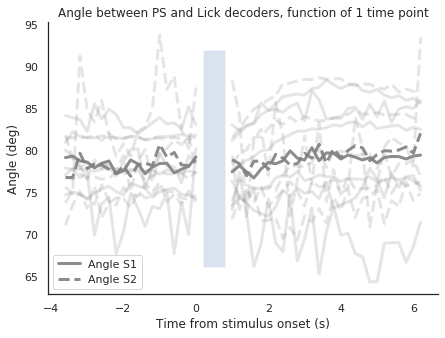

In [10]:
plt.rcParams['figure.figsize'] = (7, 5)
ax_acc = plt.subplot(111)

color_dict_stand = {}
for ii, x in enumerate(plt.rcParams['axes.prop_cycle']()):
    color_dict_stand[ii] = x['color']
    if ii > 8:
        break
        
def plot_interrupted_trace(ax, time_array, plot_array, llabel='', bool_plot_std=False,
                           plot_laser=True, ccolor='grey', plot_indiv=True,
                           plot_groupav=True):

    breakpoint = np.argmax(np.diff(time_array)) + 1# finds the 0, equivalent to art_gap_start
    time_1 = time_array[:breakpoint]
    time_2 = time_array[breakpoint:]
    mouse_list = list(plot_array.keys())
    linest = {'s1': '-', 's2': '--'}
    average_mean = {x: np.zeros(plot_array[mouse_list[0]].shape[0]) for x in region_list}
    for mouse in mouse_list:
        reg = mouse[-2:]
        if plot_array[mouse].ndim == 2:
            plot_mean = plot_array[mouse][:, 0]
        elif plot_array[mouse].ndim == 1:
            plot_mean = plot_array[mouse]
        average_mean[mouse[-2:]] += plot_mean / len(mouse_list) * 2
    #     plot_std = plot_array[:, 1]
    #     if bool_plot_std:
    #         ax_acc.fill_between(x=time_1, y1=plot_mean[:breakpoint] - plot_std[:breakpoint],
    #                            y2=plot_mean[:breakpoint] + plot_std[:breakpoint], color=ccolor, alpha=0.2)
    #         ax_acc.fill_between(x=time_2, y1=plot_mean[breakpoint:] - plot_std[breakpoint:],
    #                            y2=plot_mean[breakpoint:] + plot_std[breakpoint:], color=ccolor, alpha=0.2)
        if plot_indiv:
            ax_acc.plot(time_1, plot_mean[:breakpoint],  linewidth=3, linestyle=linest[reg], 
                        markersize=12, color=ccolor, label=None, alpha=0.2)
            ax_acc.plot(time_2, plot_mean[breakpoint:],  linewidth=3, linestyle=linest[reg], 
                        markersize=12, color=ccolor, alpha=0.2, label=None)
    if plot_groupav:
        for rr, av_mean in average_mean.items():
            ax_acc.plot(time_1, av_mean[:breakpoint],  linewidth=3, linestyle=linest[rr], 
                            markersize=12, color=ccolor, label=llabel + f' {rr.upper()}', alpha=0.9)
            ax_acc.plot(time_2, av_mean[breakpoint:], linewidth=3, linestyle=linest[rr], 
                        markersize=12, color=ccolor, alpha=0.9, label=None)
    if plot_laser:
        ax_acc.axvspan(xmin=time_1[-1] + 1 / freq, xmax=time_2[0] - 1 / freq, ymin=0.1, ymax=0.9, alpha=0.2, label=None)
    return ax_acc


mouse_list = np.unique([ss.mouse for _, ss in sessions.items()])
region_list=['s1', 's2']
freq = 5
new_time = tp_dict['mutual']
# if 'pred_dec_test' in df_prediction_test[mouse_list[0]].columns:
# plot_interrupted_trace(ax=ax_acc
#                        , plot_array=lick_acc, bool_plot_std=False,
#                        llabel='decision', ccolor=(0.00784313725490196, 0.6196078431372549, 0.45098039215686275))
# # if 'pred_stim_test' in df_prediction_test[mouse_list[0]].columns:
# plot_interrupted_trace(ax=ax_acc, plot_array=ps_acc, llabel='ps', ccolor=(0.5803921568627451, 0.5803921568627451, 0.5803921568627451))

# plot_dict_split = ps_acc_split
# for iplot, key in enumerate(np.sort(np.array(list(plot_dict_split.keys())))):
#     dict_part = plot_dict_split[key]
#     plot_interrupted_trace(ax=ax_acc, plot_array=dict_part, llabel=str(key), 
#                            ccolor=color_dict_stand[iplot], plot_indiv=True)

plot_interrupted_trace(ax=ax_acc, time_array=new_time, plot_array=angle_dec, llabel='Angle')

# plot_interrupted_trace(ax=ax_acc, plot_array=lick_half, bool_plot_std=False, llabel='0.5')
ax_acc.set_xlabel('Time from stimulus onset (s)'); ax_acc.set_ylabel('Angle (deg)')
ax_acc.legend(); ax_acc.set_title('Angle between PS and Lick decoders, function of 1 time point');
# plt.xlim([180, 220])
sns.despine()

In [11]:
tp_list = [-0.6, 1.2, 3.8]
dict_df_test = {reg: {} for reg in region_list}
for reg in region_list:
    for tp in tp_list:
        _, dict_df_test[reg][tp] = train_test_all_sessions(sessions=sessions, verbose=0,# n_split=n_split,
                                                      trial_times_use=np.array([tp]),
                                                 hitmiss_only=False,# list_test=['dec', 'stim'],
                                                 include_autoreward=True, neurons_selection=reg,
                                                 C_value=0.02, cv_regularizer=False, train_projected=True)


In [ ]:
## Complete fig:

plt.rcParams['figure.figsize'] = (12, 12)
plt.subplots_adjust(wspace=0.2, hspace=0.6)
ax_acc = plt.subplot(4, 1, (1, 2))
plot_interrupted_trace(ax=ax_acc,  time_array=new_time, plot_array=ps_acc, plot_indiv=False,
                       llabel='Average', ccolor=(0.5803921568627451, 0.5803921568627451, 0.5803921568627451))

plot_dict_split = ps_acc_split
label_split = {0: 'No lick', 1: 'Lick'}
for iplot, key in enumerate(np.sort(np.array(list(plot_dict_split.keys())))):
    dict_part = plot_dict_split[key]
    plot_interrupted_trace(ax=ax_acc, time_array=new_time, plot_array=dict_part, llabel=label_split[key], 
                           ccolor=color_dict_stand[iplot], plot_indiv=False, plot_laser=False)

ax_acc.set_xlabel('Time from stimulus onset (s)'); ax_acc.set_ylabel('Accuracy')
ax_acc.legend(loc='upper left'); ax_acc.set_title('Dynamic decoding of Photo Stimulation (PS), sliding function of 1 time point');
ax_acc.set_ylim([0.39, 0.85])
mouse = 'RL070'
ax_tp = {}
for i_reg, reg in enumerate(region_list):
    for i_tp, tp in enumerate(tp_list):
        plt.subplot(4, 3, i_tp + 7 + (3 * i_reg))
        plot_df_stats(df=dict_df_test[reg][tp][mouse], xx='true_stim_test', yy='pred_stim_test', hh='true_dec_test')  # set hh=None or hh='dec_test'
        plt.xlabel('Number of cells PS'); plt.title(f'Time: {tp}s, {reg.upper()}', weight='bold'); plt.legend([])
        plt.ylim([-0.05, 0.85])
        ax_acc.scatter([tp], [.45], marker='^', s=50, color='k')
        ax_acc.text(s=f'{tp}s', x=tp - 0.22, y=0.41)
        if i_tp == 0:
             plt.ylabel(f'Predicted PS Prob. {reg.upper()}'); 
        else:
            plt.ylabel('')

sns.despine()

In [26]:
for _, ss in sessions.items():
    print(ss)

Mouse RL070, run 28
Mouse RL070, run 29
Mouse J048, run 27
Mouse J048, run 28
Mouse J048, run 29
Mouse J048, run 30
Mouse J048, run 32
Mouse J064, run 10
Mouse J064, run 11
Mouse J064, run 14
Mouse J063, run 8
Mouse J063, run 9
Mouse RL048, run 23
Mouse RL048, run 24
Mouse RL048, run 25
Mouse RL048, run 28
Mouse RL048, run 29
Mouse J065, run 10
Mouse J065, run 11


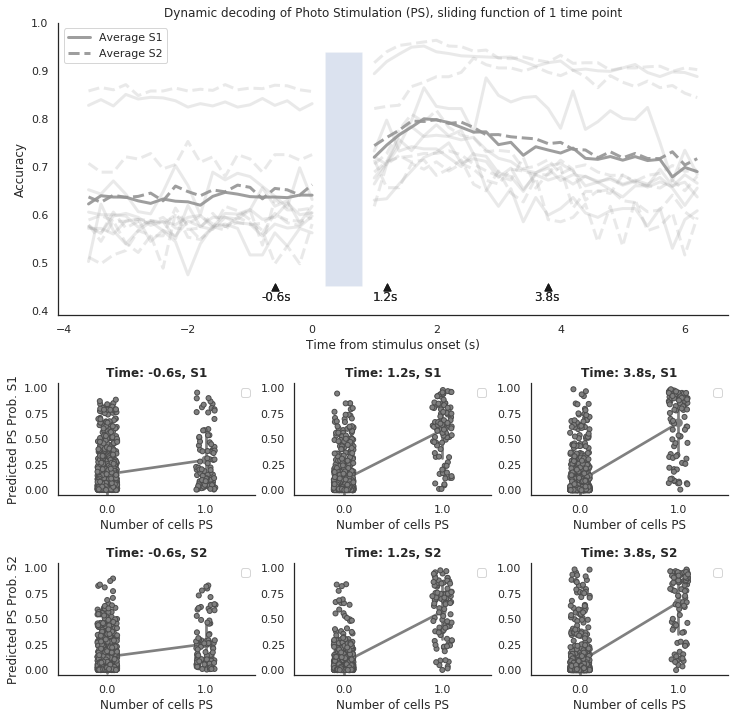

In [15]:
## Complete fig:

plt.rcParams['figure.figsize'] = (12, 12)
plt.subplots_adjust(wspace=0.2, hspace=0.6)
ax_acc = plt.subplot(4, 1, (1, 2))
plot_interrupted_trace(ax=ax_acc,  time_array=new_time,plot_array=lick_acc, llabel='Average', ccolor=(0.5803921568627451, 0.5803921568627451, 0.5803921568627451))

# plot_dict_split = ps_acc_split
# label_split = {0: 'No lick', 1: 'Lick'}
# for iplot, key in enumerate(np.sort(np.array(list(plot_dict_split.keys())))):
#     dict_part = plot_dict_split[key]
#     plot_interrupted_trace(ax=ax_acc, time_array=new_time, plot_array=dict_part, llabel=label_split[key], 
#                            ccolor=color_dict_stand[iplot], plot_indiv=True, plot_laser=False)

ax_acc.set_xlabel('Time from stimulus onset (s)'); ax_acc.set_ylabel('Accuracy')
ax_acc.legend(loc='upper left'); ax_acc.set_title('Dynamic decoding of Photo Stimulation (PS), sliding function of 1 time point');
ax_acc.set_ylim([0.39, 1])
# reg = 's2'
mouse = 'RL048'
ax_tp = {}
for i_reg, reg in enumerate(region_list):
    for i_tp, tp in enumerate(tp_list):
        plt.subplot(4, 3, i_tp + 7 + (3 * i_reg))
        plot_df_stats(df=dict_df_test[reg][tp][mouse], xx='true_dec_test', yy='pred_dec_test', hh=None)  # set hh=None or hh='dec_test'
        plt.xlabel('Number of cells PS'); plt.title(f'Time: {tp}s, {reg.upper()}', weight='bold'); plt.legend([])
        plt.ylim([-0.05, 1.05])
        ax_acc.scatter([tp], [.45], marker='^', s=50, color='k')
        ax_acc.text(s=f'{tp}s', x=tp - 0.22, y=0.42)
        if i_tp == 0:
             plt.ylabel(f'Predicted PS Prob. {reg.upper()}'); 
        else:
            plt.ylabel('')

sns.despine()

(276,)
114 138
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239
 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259 260 261 262 263 264 265 266

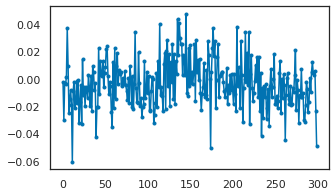

In [16]:
plt.rcParams['figure.figsize'] = (5, 3)
ss = sessions[0]
plt.plot(np.mean(ss.behaviour_trials[:, ss.photostim < 2, :], (0, 1)), '.-')
print(ss.filter_ps_array.shape)
print(ss.art_gap_start, ss.art_gap_stop)
print(ss.filter_ps_array)
print(ss.frequency, ss)
print(ss.post_frames)

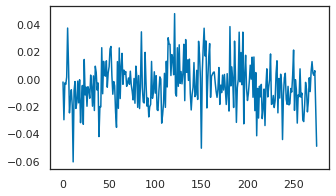

In [17]:
plt.plot(np.mean(ss.behaviour_trials[:, ss.photostim < 2, :][:, :, ss.filter_ps_array], (0, 1)))

In [153]:
for _, ss in sessions.items():
    print(_, ss)

0 Mouse RL070, run 28
1 Mouse RL070, run 29
2 Mouse J048, run 27
3 Mouse J048, run 28
4 Mouse J048, run 29
5 Mouse J048, run 30
6 Mouse J048, run 32
7 Mouse J064, run 10
8 Mouse J064, run 11
9 Mouse J064, run 14
10 Mouse J063, run 8
11 Mouse J063, run 9
12 Mouse RL048, run 23
13 Mouse RL048, run 24
14 Mouse RL048, run 25
15 Mouse RL048, run 28
16 Mouse RL048, run 29
17 Mouse J065, run 10
18 Mouse J065, run 11


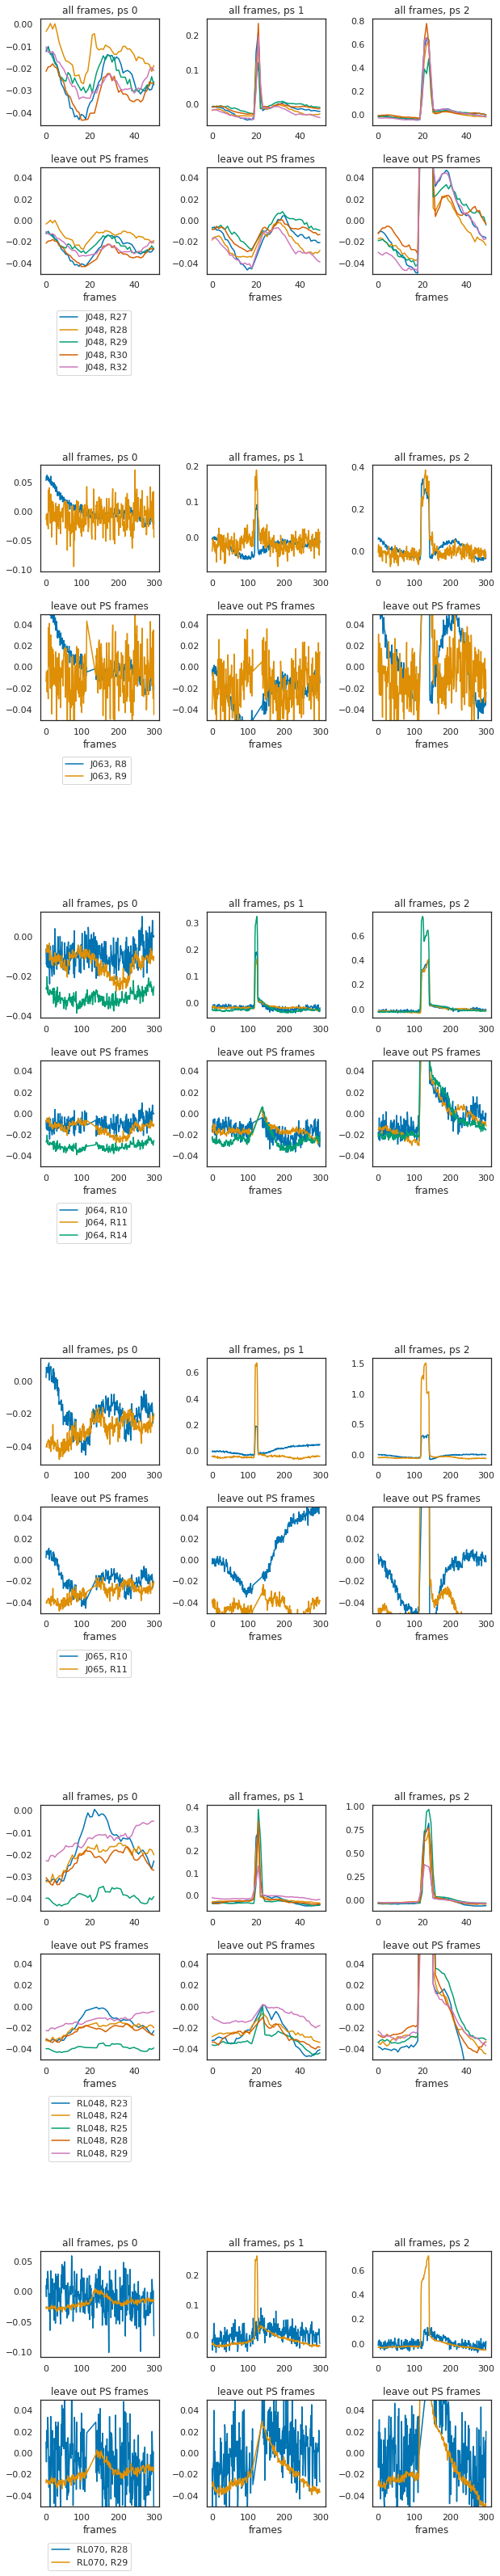

In [93]:
mouse_list = np.unique([ss.mouse for _, ss in sessions.items()])

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.rcParams['figure.figsize'] = (10, 60)

# mouse = mouse_list[5]
# mouse_list = mouse_list[:2]
for i_m, mouse in enumerate(mouse_list):
    for _, ss in sessions.items():
        if ss.mouse == mouse:
            for i_ps in range(3):
                plt.subplot(3 * len(mouse_list), 3, 1 + i_ps + 9 * i_m)
                plt.plot(np.mean(ss.behaviour_trials[:, ss.photostim == i_ps, :], (0, 1)), label=f'{mouse}, R{ss.run_number}')
                plt.title(f'all frames, ps {i_ps}')
    #             plt.legend()

                plt.subplot(3 * len(mouse_list), 3, 4 + i_ps  + 9 * i_m)
                plt.plot(ss.filter_ps_array, np.mean(ss.behaviour_trials[:, ss.photostim == i_ps, :][:, :, ss.filter_ps_array], (0, 1)),
                         label=f'{mouse}, R{ss.run_number}')
                plt.xlabel('frames'); plt.title('leave out PS frames'); plt.ylim([-0.05, 0.05])
                if i_ps == 2:
                    plt.legend(bbox_to_anchor=(-2, -0.3))
                    
# plt.tight_layout()
plt.savefig('average_all_sessions.pdf')


(array([535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535, 535,
       535, 535, 535, 535, 535, 535, 535, 535, 535, 535]), array([121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143]))


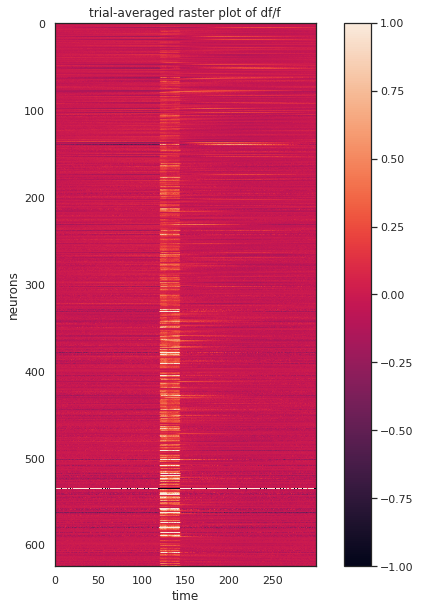

In [110]:
def dfof2(flu):
    '''
    delta f over f, this function is orders of magnitude faster 
    than the dumb one above takes input matrix flu 
    (num_cells x num_frames)
    (JR 2019)
    '''

    flu_mean = np.mean(flu, 1)
    flu_mean = np.reshape(flu_mean, (len(flu_mean), 1))
    return (flu - flu_mean) / flu_mean

# tmp = np.random.randn(2, 100) + 3

# plt.rcParams['figure.figsize'] = (5, 3)
# plt.plot(dfof2(tmp).T)
# plt.plot(tmp.T)

plt.rcParams['figure.figsize'] = (10, 10)
plt.imshow(np.clip(np.mean(sessions[0].behaviour_trials, 1), a_max=1, a_min=-1))
plt.colorbar()
plt.ylabel('neurons'); plt.xlabel('time'); plt.title('trial-averaged raster plot of df/f')

print(np.where(np.mean(sessions[0].behaviour_trials, 1) < -50))

In [129]:
print(sessions[0])

Mouse RL070, run 28


## ideas to improve / directions to go

#### Current plot:

- Distribution weight matrix
- plot \Delta W(t, t-1)

#### Try to find a function of the data that enhances the readout.

- Dimensionality reduction (dPCA should be ideal, theoretically)


#### S1 / S2 comparison

- Add dynamic prediction between populations -> subspaces -> Same question as with semedo data (i.e. different neurons that predict S2 or decode stim)

- Use increasing/decreasing number of neurons